<a href="https://colab.research.google.com/github/syifanurul/Malaria-Cells-Image-Recognition/blob/master/Malaria_Cell_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MALARIA CELLS IMAGE RECOGNITION**

Classification of Malaria Cells Identification in Red Blood Cells Using Tensorflow


**Group Members:** 
1. Raynald Masli
2. Syifa Nurul Fatimah

## **Import Packages**

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import os
import cv2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **Download Data from Kaggle**

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"syifanurulfatimah","key":"04473f0e3da52d60c9ce705ba483ed83"}'}

In [3]:
!ls -lha kaggle.json #Make sure that kaggle.json has already upload

-rw-r--r-- 1 root root 73 Apr  2 14:33 kaggle.json


In [0]:
!pip install -q kaggle #kaggle library installation

In [6]:
#Access the Kaggle dataset for data input
!mkdir -p~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list #Asking for Kaggle dataset


mkdir: invalid option -- '~'
Try 'mkdir --help' for more information.
ref                                                            title                                                size  lastUpdated          downloadCount  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge              COVID-19 Open Research Dataset Challenge (CORD-19)  729MB  2020-03-27 23:46:53          39819  
ryanxjhan/cbc-news-coronavirus-articles-march-26               CBC News Coronavirus/COVID-19 Articles (NLP)          6MB  2020-03-27 23:23:07            125  
danevans/world-bank-wdi-212-health-systems                     World Bank WDI 2.12 - Health Systems                  6KB  2020-03-29 19:00:14            178  
vitaliymalcev/russian-passenger-air-service-20072020           Russian passenger air service 2007-2020             114KB  2020-03-29 17

In [8]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria #malaria-cells-images download from Kaggle

 99% 669M/675M [00:15<00:00, 44.8MB/s]
100% 675M/675M [00:15<00:00, 47.0MB/s]


## **Data Preparation**

In [0]:

import zipfile

#Extract the file from zip file
images = zipfile.ZipFile("/content/cell-images-for-detecting-malaria.zip", 'r')
images.extractall("/content")
images.close()


In [0]:
#Assign the images into either the infected cells and uninfected cells 

infected_cells = os.listdir("/content/cell_images/Parasitized")
uninfected_cells = os.listdir("/content/cell_images/Uninfected")

In [11]:
#Transform and resize the all the images into the 75x75 matrices of pixels
import keras.preprocessing.image as im
picture = []
label = []

for infect in infected_cells :
  try :
    if infect != 'Thumbs.db':
      image = "/content/cell_images/Parasitized/"+infect
      img_array = im.img_to_array(im.load_img(image, target_size = (75,75), interpolation = 'nearest'), dtype = 'uint8')
      picture.append(np.array(img_array))
      label.append(1)

  except FileNotFoundError:
    continue

for uninfect in uninfected_cells :
  try :
    if uninfect != 'Thumbs.db':
      image = "/content/cell_images/Uninfected/"+uninfect
      img_array = im.img_to_array(im.load_img(image, target_size = (75,75), interpolation = 'nearest'), dtype = 'uint8')
      picture.append(np.array(img_array))
      label.append(0)

  except FileNotFoundError:
    continue


Using TensorFlow backend.


In [12]:
#Initialization of image data parameters
data = np.array(picture)
labels = np.array(label)

#Checks the total of rgb images array and the labels of them
np.save('data', data)
np.save('labels', labels)

print ('data : {}, labels : {}'.format(data.shape, labels.shape))

data : (27558, 75, 75, 3), labels : (27558,)


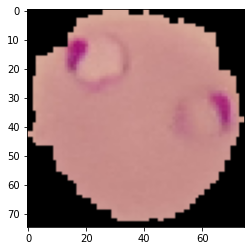

In [13]:
#Plot an example of the data
plt.imshow(data[3])

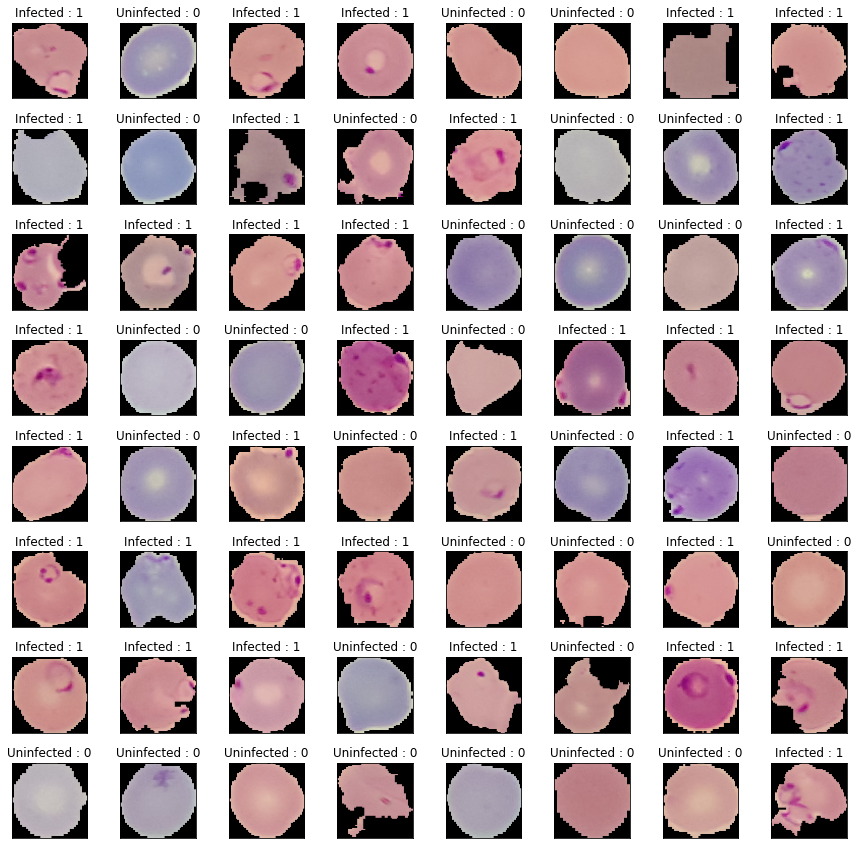

In [14]:
#Plot and preview the pictures and its label
plt.figure(num = 1, figsize = (15,15))

for n in range (1,65) :
  val = np.random.randint(0, data.shape[0], 1)
  plt.subplot(8, 8, n)
  plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
  plt.imshow(data[val[0]])
  plt.title('{} : {}'.format('Uninfected' if labels[val[0]] == 0 else 'Infected', labels[val[0]]))
  plt.yticks([])
  plt.xticks([])

plt.show()

In [0]:
#Data Randomization
arranger = np.arange(data.shape[0])
np.random.shuffle(arranger)
data = data[arranger]
labels = labels[arranger]

# **Data Preparation Conclusion**


*   Images are transformed into 75x75 pixels matrix in feature 'data' 
*   Labels of the images (infected and uninfected) is determined in feature 'labels'
*   All the dataset has been randomized





## **Model Creation**

1.   Training and testing dataset 

2.   Build the model

2.   Model summary

3.   Compile the model

4.   Train and test the model

5.   Save the model

6.   Visualize training result



### **Training and Tesing Dataset**

In [0]:
#Split the data into training and testing dataset
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size = 0.25)

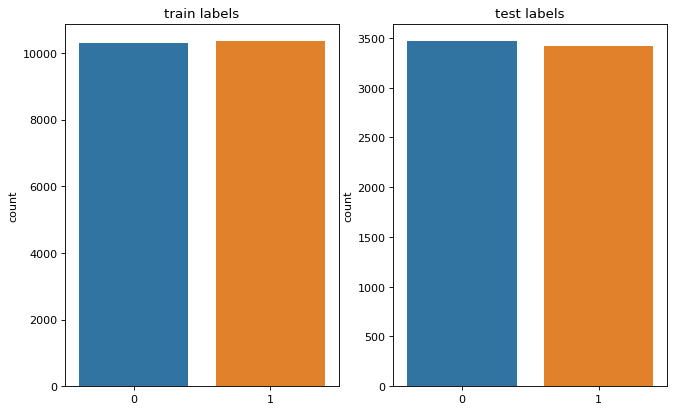

In [17]:
#Data amount confirmation
plt.figure(1, figsize = (15,6), dpi = 80)
num_fig = 0

for pic, title in zip ([Y_train, Y_test], ['train labels', 'test labels']) :
  num_fig += 1
  plt.subplot(1, 3, num_fig)
  sb.countplot (x = pic)
  plt.title(title)

plt.show()

### **Build the Model**

In [0]:
#Create model with function
def Convmodel (filllayer, mode = 'relu'):
  model = Sequential()
  model.add(Conv2D(filllayer.pop(0), (3,3), input_shape = (75,75,3)))
  if mode == 'relu' : model.add(Activation('relu'))  
  elif mode == 'leakyrelu' : model.add(LeakyReLU())
  elif mode == 'prelu' : PReLU(Constant(value = 0.25))
  else : raise AttributeError(
      'mode only has 3 methods \'relu\', \'leakyrelu\',and \'prelu\'')

  for i,neurons in enumerate (filllayer):  
    model.add(Conv2D(neurons, (3,3), input_shape = (75,75,3)))
    if mode == 'relu' : model.add(Activation('relu'))  
    elif mode == 'leakyrelu' : model.add(LeakyReLU())
    elif mode == 'prelu' : PReLU(Constant(value = 0.25))
    else : raise AttributeError(
      'mode only has 3 methods \'relu\', \'leakyrelu\', and \'prelu\'')
    model.add(MaxPooling2D((2,2)))

  model.add(Flatten())
  model.add(Dense(512))
  if mode == 'relu' : model.add(Activation('relu'))  
  elif mode == 'leakyrelu' : model.add(LeakyReLU())
  elif mode == 'prelu' : PReLU(Constant(value = 0.25))
  else : raise AttributeError(
      'mode only has 3 methods \'relu\', \'leakyrelu\', and \'prelu\'')
  model.add(Dropout(0.5))
  model.add(Dense(64))
  if mode == 'relu' : model.add(Activation('relu'))  
  elif mode == 'leakyrelu' : model.add(LeakyReLU())
  elif mode == 'prelu' : PReLU(Constant(value = 0.25))
  else : raise AttributeError(
      'mode only has 3 methods \'relu\', \'leakyrelu\', and \'prelu\'')
  model.add(Dense(1, activation = 'sigmoid'))

  return model

### **Model Summary**

In [19]:
model1 = Convmodel([32,64,128,256,512], mode = 'leakyrelu')
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 71, 71, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 128)       73856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 33, 33, 128)       0

In [20]:
model2 = Convmodel([32,64,128,256,512], mode = 'relu')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 73, 73, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 71, 71, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 33, 33, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 33, 33, 128)      

In [21]:
model3 = Convmodel([32,64,128,256,512], mode = 'prelu')
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 73, 73, 32)        896       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 33, 33, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 256)       295168    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 256)        

### **Compile the Model**

In [0]:
model1.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(learning_rate = 0.001),
                   metrics=['accuracy'])
model2.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(learning_rate = 0.001),
                   metrics=['accuracy'])
model3.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(learning_rate = 0.001),
                   metrics=['accuracy'])

### **Train and Test the Model**

In [0]:
batch_size = 32
epochs = 30
ntrain = len(X_train)
nval = len(X_test)

In [0]:
train_datagen = ImageDataGenerator(rescale = 1/225, horizontal_flip = True, vertical_flip = True, rotation_range = 30)

In [0]:
train_datagen = train_datagen.flow(X_train, Y_train, batch_size = batch_size)

In [26]:
history1 = model1.fit_generator(train_datagen,
                              steps_per_epoch = ntrain // batch_size,
                              epochs = epochs)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
645/645 [==============================] - 26s 40ms/step - loss: 0.3285 - accuracy: 0.8643
Epoch 2/30
645/645 [==============================] - 26s 40ms/step - loss: 0.2257 - accuracy: 0.9225
Epoch 3/30
645/645 [==============================] - 26s 40ms/step - loss: 0.2160 - accuracy: 0.9278
Epoch 4/30
645/645 [==============================] - 26s 40ms/step - loss: 0.2123 - accuracy: 0.9299
Epoch 5/30
645/645 [==============================] - 26s 40ms/step - loss: 0.2023 - accuracy: 0.9314
Epoch 6/30
645/645 [==============================] - 26s 40ms/step - loss: 0.1954 - accuracy: 0.9343
Epoch 7/30
645/645 [==============================] - 26s 40ms/step - loss: 0.1966 - accuracy: 0.9325
Epoch 8/30
645/645 [==============================] - 26s 40ms/step - loss: 0.1894 - accuracy: 0.9384
Epoch 9/30
645/645 [==============================] - 26s 40ms/step - loss: 0.1907 - accuracy: 0.9347
Epoch 

In [27]:
history2 = model2.fit_generator(train_datagen,
                              steps_per_epoch = ntrain // batch_size,
                              epochs = epochs)

Epoch 1/30
645/645 [==============================] - 25s 39ms/step - loss: 0.3558 - accuracy: 0.8411
Epoch 2/30
645/645 [==============================] - 26s 40ms/step - loss: 0.2316 - accuracy: 0.9200
Epoch 3/30
645/645 [==============================] - 25s 39ms/step - loss: 0.2111 - accuracy: 0.9271
Epoch 4/30
645/645 [==============================] - 25s 39ms/step - loss: 0.2070 - accuracy: 0.9282
Epoch 5/30
645/645 [==============================] - 25s 39ms/step - loss: 0.2003 - accuracy: 0.9308
Epoch 6/30
645/645 [==============================] - 25s 39ms/step - loss: 0.1898 - accuracy: 0.9337
Epoch 7/30
645/645 [==============================] - 25s 39ms/step - loss: 0.1916 - accuracy: 0.9306
Epoch 8/30
645/645 [==============================] - 25s 39ms/step - loss: 0.1889 - accuracy: 0.9348
Epoch 9/30
645/645 [==============================] - 25s 39ms/step - loss: 0.1828 - accuracy: 0.9356
Epoch 10/30
645/645 [==============================] - 25s 40ms/step - loss: 0.185

In [28]:
history3 = model3.fit_generator(train_datagen,
                              steps_per_epoch = ntrain // batch_size,
                              epochs = epochs)

Epoch 1/30
645/645 [==============================] - 25s 39ms/step - loss: 0.4214 - accuracy: 0.8178
Epoch 2/30
645/645 [==============================] - 25s 39ms/step - loss: 0.2613 - accuracy: 0.9040
Epoch 3/30
645/645 [==============================] - 25s 39ms/step - loss: 0.2407 - accuracy: 0.9153
Epoch 4/30
645/645 [==============================] - 25s 39ms/step - loss: 0.2347 - accuracy: 0.9179
Epoch 5/30
645/645 [==============================] - 25s 39ms/step - loss: 0.2223 - accuracy: 0.9220
Epoch 6/30
645/645 [==============================] - 25s 38ms/step - loss: 0.2212 - accuracy: 0.9246
Epoch 7/30
645/645 [==============================] - 25s 38ms/step - loss: 0.2252 - accuracy: 0.9227
Epoch 8/30
645/645 [==============================] - 25s 39ms/step - loss: 0.2239 - accuracy: 0.9223
Epoch 9/30
645/645 [==============================] - 25s 39ms/step - loss: 0.2152 - accuracy: 0.9264
Epoch 10/30
645/645 [==============================] - 25s 38ms/step - loss: 0.212

### **Save the Model**

In [29]:
model1.save_weights('model_weights.1')
model1.save('model_keras.1')
model2.save_weights('model_weights.1')
model2.save('model_keras.1')
model3.save_weights('model_weights.1')
model3.save('model_keras.1')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_keras.1/assets
INFO:tensorflow:Assets written to: model_keras.1/assets
INFO:tensorflow:Assets written to: model_keras.1/assets


### **Visualize Training Result**

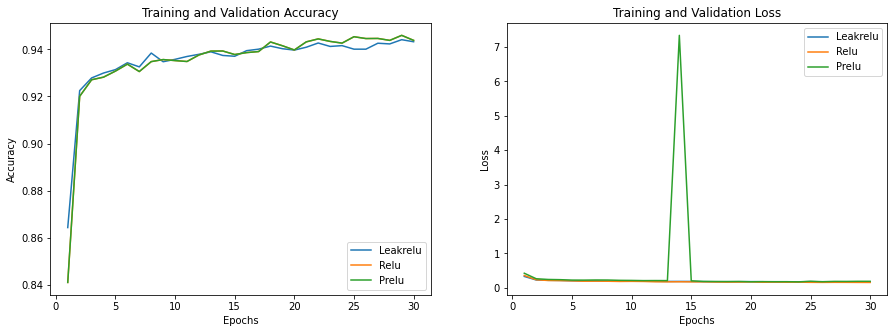

In [33]:
#Plot the training accuracy and loss
acc1 = history1.history['accuracy']
loss1 = history1.history['loss']
acc2 = history2.history['accuracy']
loss2 = history2.history['loss']
acc3 = history3.history['accuracy']
loss3 = history3.history['loss']

epochs_range = range(1, len(acc1) + 1)
num_fig = 0

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc1, label='Leakrelu')
plt.plot(epochs_range, acc2, label='Relu')
plt.plot(epochs_range, acc2, label='Prelu')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss1, label='Leakrelu')
plt.plot(epochs_range, loss2, label='Relu')
plt.plot(epochs_range, loss3, label='Prelu')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


#for met, col, ylab, title in zip ([acc1, loss1], ['red', 'green'], ['Accuracy', 'Loss'], ['Training Accuracy', 'Training Loss']):
#  plt.figure(figsize = (15,5))
#  num_fig += 1
#  plt.subplot(1,2, num_fig)
#  plt.plot(epochs_range, met, col)
#  plt.title(title)
#  plt.xlabel('Epochs')
#  plt.ylabel(ylab)

#plt.show()

Test Accuracy 
 Leakrelu = 93.90% 
 Relu = 65.75% 
 Prelu = 93.29%
Test Prediction 
 Leakrelu = 92.46% 
 Relu = 95.47% 
 Prelu = 95.65%
Test Recall 
 Leakrelu = 95.13% 
 Relu = 59.70% 
 Prelu = 91.27%
Test f1 Score 
 Leakrelu = 93.78% 
 Relu = 73.47% 
 Prelu = 93.41%


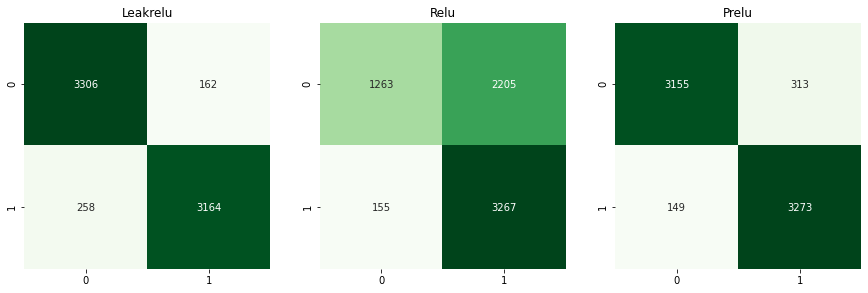

In [41]:
#Test result conclusion
import tensorflow.keras.metrics as mts
def conc_model(model1, model2, model3):
  plt.figure(figsize = (15,5))
  #model1
  plt.subplot(1, 3, 1)
  y_pred_1 = model1.predict(X_test)
  y_pred_1 = np.where(y_pred_1 > 0.5, 1, 0)
  conf_matrix_1 = np.array(tf.math.confusion_matrix(labels = Y_test, predictions = y_pred_1))
  acc_1 = (conf_matrix_1[0,0] + conf_matrix_1[1,1])/(conf_matrix_1[0,0] + conf_matrix_1[1,1] + conf_matrix_1[1,0] + conf_matrix_1[0,1])*100
  prec_1 = conf_matrix_1[1,1]/(conf_matrix_1[1,1] + conf_matrix_1[1,0])*100
  rec_1 = conf_matrix_1[1,1]/(conf_matrix_1[1,1] + conf_matrix_1[0,1])*100
  f1_score_1 = 2*prec_1*rec_1/(prec_1 + rec_1)
  sb.heatmap(conf_matrix_1, fmt = 'd', annot = True, square = True, cbar = False, cmap = 'Greens')
  plt.title('Leakrelu')
  #model2
  plt.subplot(1, 3, 2)
  y_pred_2 = model2.predict(X_test)
  y_pred_2 = np.where(y_pred_2 > 0.5, 1, 0)
  conf_matrix_2 = np.array(tf.math.confusion_matrix(labels = Y_test, predictions = y_pred_2))
  acc_2 = (conf_matrix_2[0,0] + conf_matrix_2[1,1])/(conf_matrix_2[0,0] + conf_matrix_2[1,1] + conf_matrix_2[1,0] + conf_matrix_2[0,1])*100
  prec_2 = conf_matrix_2[1,1]/(conf_matrix_2[1,1] + conf_matrix_2[1,0])*100
  rec_2 = conf_matrix_2[1,1]/(conf_matrix_2[1,1] + conf_matrix_2[0,1])*100
  f1_score_2 = 2*prec_2*rec_2/(prec_2 + rec_2)
  sb.heatmap(conf_matrix_2, fmt = 'd', annot = True, square = True, cbar = False, cmap = 'Greens')
  plt.title('Relu')
  #model3
  plt.subplot(1, 3, 3)
  y_pred_3 = model3.predict(X_test)
  y_pred_3 = np.where(y_pred_3 > 0.5, 1, 0)
  conf_matrix_3 = np.array(tf.math.confusion_matrix(labels = Y_test, predictions = y_pred_3))
  acc_3 = (conf_matrix_3[0,0] + conf_matrix_3[1,1])/(conf_matrix_3[0,0] + conf_matrix_3[1,1] + conf_matrix_3[1,0] + conf_matrix_3[0,1])*100
  prec_3 = conf_matrix_3[1,1]/(conf_matrix_3[1,1] + conf_matrix_3[1,0])*100
  rec_3 = conf_matrix_3[1,1]/(conf_matrix_3[1,1] + conf_matrix_3[0,1])*100
  f1_score_3 = 2*prec_3*rec_3/(prec_3 + rec_3)
  sb.heatmap(conf_matrix_3, fmt = 'd', annot = True, square = True, cbar = False, cmap = 'Greens')
  plt.title('Prelu')
  print('Test Accuracy \n Leakrelu = {:.2f}% \n Relu = {:.2f}% \n Prelu = {:.2f}%'.format(acc_1, acc_2, acc_3))
  print('Test Prediction \n Leakrelu = {:.2f}% \n Relu = {:.2f}% \n Prelu = {:.2f}%'.format(prec_1, prec_2, prec_3))
  print('Test Recall \n Leakrelu = {:.2f}% \n Relu = {:.2f}% \n Prelu = {:.2f}%'.format(rec_1, rec_2, rec_3))
  print('Test f1 Score \n Leakrelu = {:.2f}% \n Relu = {:.2f}% \n Prelu = {:.2f}%'.format(f1_score_1,f1_score_2,f1_score_3))
  plt.show()

conc_model(model1,model2,model3)

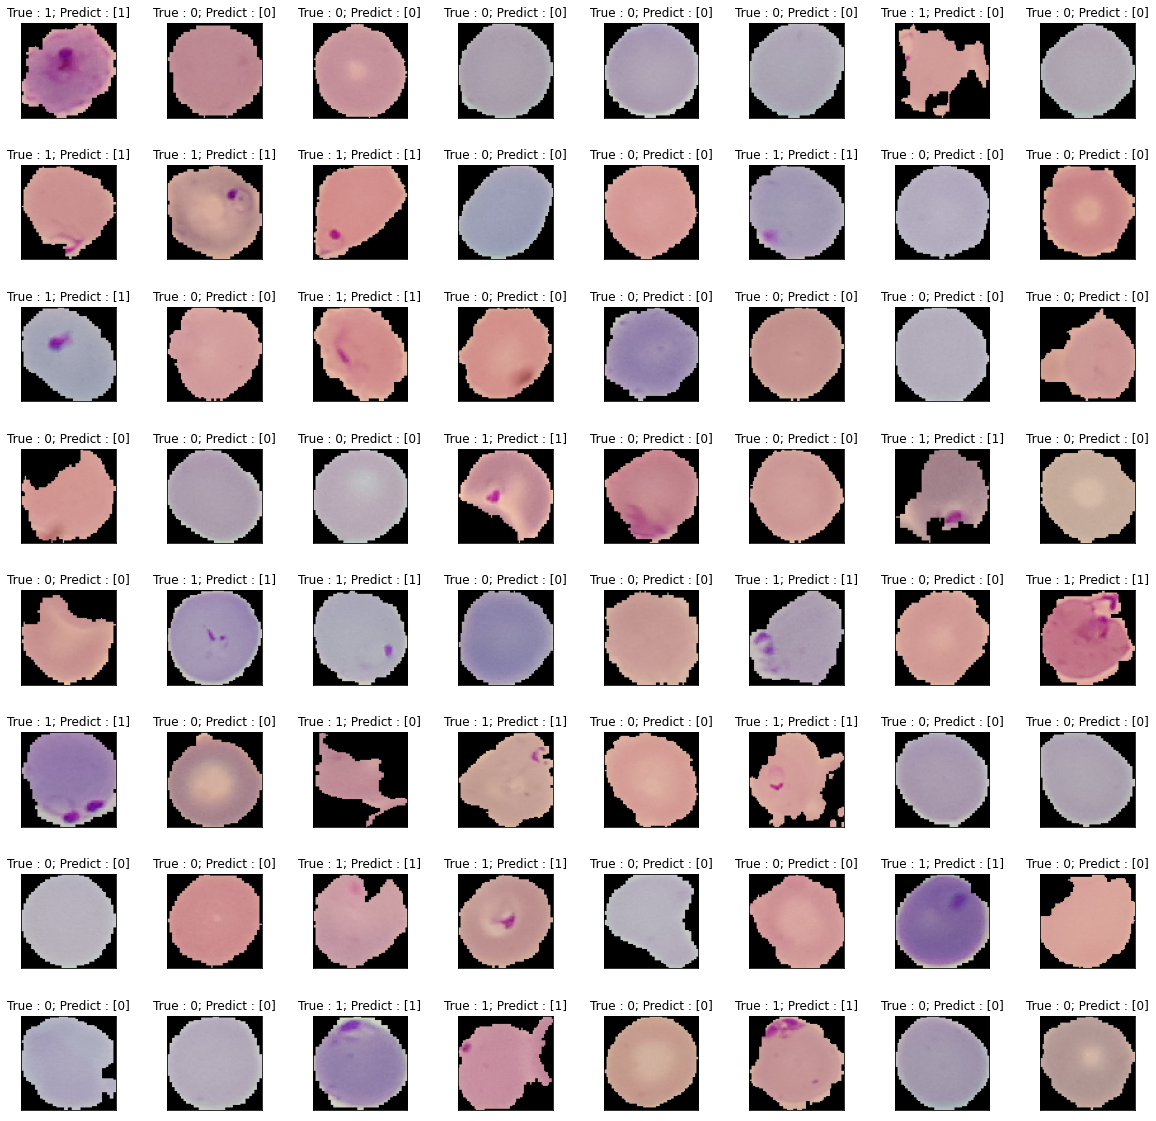

In [42]:
#plot the train test result
y_pred = model1.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

plt.figure(num = 1, figsize = (20,20))

for n in range (1,65) :
  val = np.random.randint(0, X_test.shape[0], 1)
  plt.subplot(8, 8, n)
  plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
  plt.imshow(X_test[val[0]])
  plt.title('True : {}; Predict : {}'.format(Y_test[val[0]], y_pred[val[0]]))
  plt.yticks([])
  plt.xticks([])

plt.show()